In [1]:
import numpy as np

In [2]:
Y = np.array([3.23, 5.38, 6.54, 7.99, 9.86, 11.35, 11.98])
X = np.array([1,2,3,4,5,6,7])

In [3]:
N = len(Y)
x = np.mean(X)
y = np.mean(Y)
xy = np.mean(X*Y)
x2 = np.mean(X*X)
y2 = np.mean(Y*Y)

In [4]:
N, x, y

(7, 4.0, 8.047142857142857)

In [5]:
x2, xy, y2

(20.0, 38.11857142857143, 73.65021428571428)

### MAP + Laplace

In [6]:
a_map = (xy - x*y) / (x2 - x**2)
c_map = y - x * a_map
sigma2_map = 1/(N+2) * np.sum((Y - (a_map * X + c_map))**2)

In [7]:
a_map, c_map, sigma2_map

(1.4825, 2.1171428571428574, 0.07970753968253955)

In [8]:
stdL_a = np.sqrt(sigma2_map / N / (x2 - x**2))
stdL_c = np.sqrt(sigma2_map / N * x2 / (x2 - x**2))
covL_ac = - sigma2_map / N * x / (x2 - x**2)
corrL_ac = covL_ac / np.sqrt(stdL_a * stdL_c)
stdL_sigma2 = np.sqrt(2/(N+2)) * sigma2_map

In [9]:
stdL_a, stdL_c, corrL_ac, stdL_sigma2

(0.053354454788752025,
 0.23860837562017742,
 -0.10091905583880308,
 0.037574494547479693)

### MCMC

In [10]:
import pystan

In [11]:
model_code = """
data {
    int<lower=1> N;
    real x[N];
    real y[N];
}
parameters {
    real a;
    real c;
    real<lower=0> sigma2;
}
model {
    target += -log(sigma2);
    for (i in 1:N){
        target += normal_lpdf(y[i] | a * x[i] + c, sqrt(sigma2));
    }
}
"""
model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2ec1c47dd025e7a849c6af7080b56fd9 NOW.


In [12]:
data = {'N': N, 'x': X, 'y': Y}

In [13]:
fit = model.sampling(data=data, seed=123456, iter=100_000, thin=10)

/usr/local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [14]:
samples = fit.extract()

In [15]:
np.mean(samples['a']), np.median(samples['a'])

(1.482332944393399, 1.4820993999002012)

In [16]:
np.mean(samples['c']), np.median(samples['c'])

(2.1194386202854605, 2.1201645898036947)

In [17]:
np.mean(samples['sigma2']), np.median(samples['sigma2'])

(0.23770765427961266, 0.16385130210599086)

In [18]:
np.std(samples['a']), np.std(samples['c']), np.std(samples['sigma2'])

(0.0920423924063783, 0.413014243221986, 0.28280074142328665)

In [19]:
Cov = np.cov([samples[par] for par in ['a', 'c', 'sigma2']])

In [20]:
Cov[0,1] / np.sqrt(Cov[0,0] * Cov[1,1])

-0.8907918538161765

In [21]:
inv_sqrt_std_diag = np.diag(np.diag(np.sqrt(1.0 / np.abs(Cov))))

In [22]:
Corr = inv_sqrt_std_diag.dot(Cov).dot(inv_sqrt_std_diag)

In [23]:
Corr

array([[ 1.        , -0.89079185,  0.03771061],
       [-0.89079185,  1.        , -0.03117509],
       [ 0.03771061, -0.03117509,  1.        ]])

### Exact

In [24]:
Xmat = np.zeros([len(X), 2])
Xmat[:,0] = X
Xmat[:,1] = 1

In [25]:
Xmat

array([[1., 1.],
       [2., 1.],
       [3., 1.],
       [4., 1.],
       [5., 1.],
       [6., 1.],
       [7., 1.]])

In [26]:
Y

array([ 3.23,  5.38,  6.54,  7.99,  9.86, 11.35, 11.98])

In [27]:
Lambda = np.linalg.inv(Xmat.T.dot(Xmat) / N)
print(Lambda)

[[ 0.25 -1.  ]
 [-1.    5.  ]]


In [28]:
bbar = 1/N * Lambda.dot((Xmat.T).dot(Y))
print(bbar)

[1.4825     2.11714286]


In [29]:
abar, cbar = bbar

In [30]:
diff = (Y - Xmat.dot(bbar))
vbar = 1/N * diff.T.dot(diff)
print(vbar)

0.10248112244897938


In [31]:
K = 2

In [32]:
N*vbar / (N - K - 2)

0.23912261904761856

In [33]:
N*vbar / (N - K + 3)

0.08967098214285696

In [34]:
varb = vbar / (N - K - 2) * Lambda
print(varb)

[[ 0.00854009 -0.03416037]
 [-0.03416037  0.17080187]]


In [35]:
np.sqrt(2) * N *vbar / (N-K-2) / np.sqrt(N - K -4)

0.3381704509273171

In [36]:
np.sqrt(varb[0,0])

0.09241262650425508

In [37]:
np.sqrt(varb[1,1])

0.41328182968562627

In [77]:
Lambda[0,1] / np.sqrt(Lambda[0,0] * Lambda[1,1])

-0.8944271909999159

### Plot

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
import numpy as np

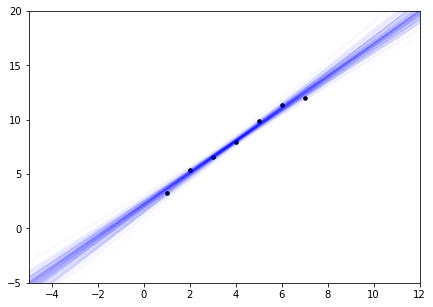

In [62]:
lines = 200

x_draw = np.linspace(-5,15, 10)

plt.figure(figsize=(7,5))
plt.plot(X, Y, 'k.', ms=7, label='data')

selected_sample_idxs = np.random.choice(len(samples['a']), size=lines)
selected_a = samples['a'][selected_sample_idxs]
selected_c = samples['c'][selected_sample_idxs]
for i in range(lines):
    a = selected_a[i]
    c = selected_c[i]
    y_draw = x_draw * a + c
    plt.plot(x_draw, y_draw, 'b-', alpha=0.02)

plt.plot([], [], 'b-', label='MCMC samples')
plt.xlim([-5,12])
plt.ylim([-5,20])
plt.show()

In [53]:
np.random.choice

<function RandomState.choice>

In [84]:
from scipy.stats import t as tdist
from scipy.stats import norm
from scipy.stats import invgamma

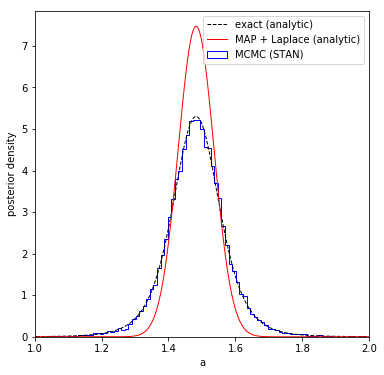

In [114]:
plt.figure(figsize=(6,6))
x = np.linspace(0, 3, 1000)
plt.plot(x, tdist.pdf(x, df=N-K, loc=abar, scale=np.sqrt(varb[0,0] * (N-K-2) / (N-K))), 
         'k--', lw=1, label='exact (analytic)')
plt.plot(x, norm.pdf(x, loc=abar, scale=stdL_a), 
         'r-', lw=1, label='MAP + Laplace (analytic)')
plt.hist(samples['a'], 
         color='b', bins=150,
         density=True, label='MCMC (STAN)', histtype='step')


plt.xlabel('a')
plt.ylabel('posterior density')
plt.xlim([1,2])
plt.legend()

plt.savefig('./P1_a_posterior.pdf', bbox_inches='tight')
plt.show()

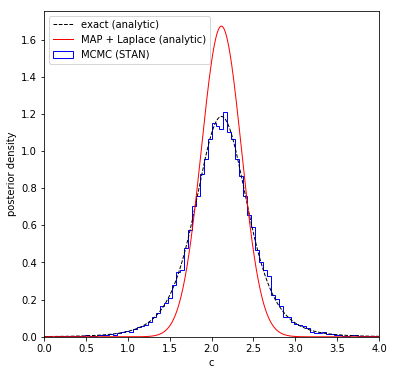

In [113]:
plt.figure(figsize=(6,6))
x = np.linspace(0, 6, 1000)
plt.plot(x, tdist.pdf(x, df=N-K, loc=cbar, scale=np.sqrt(varb[1,1] * (N-K-2) / (N-K))), 
         'k--', lw=1, label='exact (analytic)')
plt.plot(x, norm.pdf(x, loc=cbar, scale=stdL_c), 
         'r-', lw=1, label='MAP + Laplace (analytic)')
plt.hist(samples['c'], 
         color='b', bins=150,
         density=True, label='MCMC (STAN)', histtype='step')


plt.xlabel('c')
plt.ylabel('posterior density')
plt.xlim([0,4])
plt.legend()

plt.savefig('./P1_c_posterior.pdf', bbox_inches='tight')
plt.show()

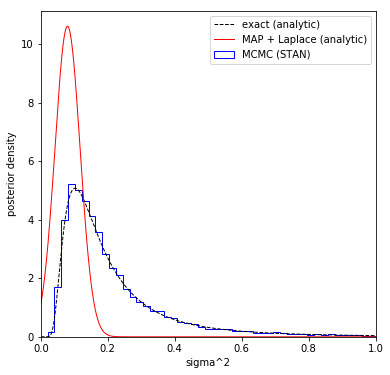

In [112]:
plt.figure(figsize=(6,6))
x = np.linspace(0, 1, 1000)
plt.plot(x, invgamma.pdf(x, a=(N-K)/2, scale=N*vbar/2), 
         'k--', lw=1, label='exact (analytic)')
plt.plot(x, norm.pdf(x, loc=sigma2_map, scale=stdL_sigma2), 
         'r-', lw=1, label='MAP + Laplace (analytic)')
plt.hist(samples['sigma2'], 
         color='b', bins=np.linspace(0,1,50),
         density=True, label='MCMC (STAN)', histtype='step')


plt.xlabel('sigma^2')
plt.ylabel('posterior density')
plt.xlim([0,1])
plt.legend()

plt.savefig('./P1_sigma2_posterior.pdf', bbox_inches='tight')
plt.show()

In [105]:
from scipy.special import gamma

def multivariate_t_distribution_pdf(x, mu, Sigma, df):
    '''
    Multivariate t-student density:
    output:
        the density of the given element
    input:
        x = parameter (d dimensional numpy array or scalar)
        mu = mean (d dimensional numpy array or scalar)
        Sigma = scale matrix (dxd numpy array)
        df = degrees of freedom
    '''
    assert Sigma.shape[0] == Sigma.shape[1]
    Sigma_inv = np.linalg.inv(Sigma)
    K = Sigma.shape[0]
    normalization = 1/ ( (np.pi * df)**(K/2) * np.sqrt(np.linalg.det(Sigma))) * gamma((df + K)/2) / gamma(df/2) 
    
    mu_spread = np.zeros_like(x)
    for idx, mu_value in enumerate(mu):
        mu_spread[..., idx] = mu_value
    diff = x - mu_spread
    
    matrix_product = np.einsum('...k,kl,...l->...', diff, Sigma_inv, diff)
    
    return normalization * (1 + matrix_product / df) ** ((-df + K) /2)

In [95]:
from scipy.stats import multivariate_normal

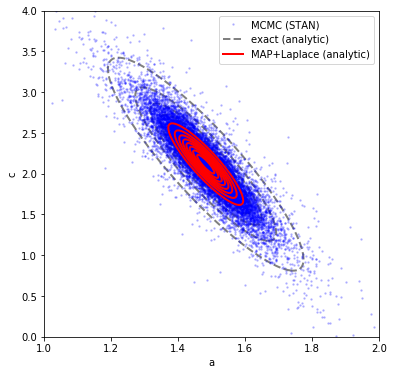

In [111]:
a_grid = np.linspace(1, 2, 300)
c_grid = np.linspace(0, 4, 300)
a, c = np.meshgrid(a_grid, c_grid)

xy = np.zeros([len(a), len(c), 2])
xy[:, :, 0] = a
xy[:, :, 1] = c

Zexact = multivariate_t_distribution_pdf(xy, bbar, vbar * Lambda / (N-K), N-K)

xy_mean = np.array([abar, cbar])
xy_cov = np.array([[stdL_a**2, covL_ac], [covL_ac, stdL_c**2]])
ZLaplace = multivariate_normal.pdf(xy, mean=xy_mean, cov=xy_cov)


plt.figure(figsize=(6,6))

plt.plot(samples['a'], samples['c'], 
         'b.', ms=3, alpha=0.2,
         label='MCMC (STAN)')

levels = np.linspace(0, np.max(Zexact), 10)
plt.contour(a, c, Zexact, levels, 
            linewidths=2, linestyles='--', colors='gray', zorder=1)
plt.plot([],[], ls='--', lw=2, color='gray', 
         label='exact (analytic)')

levels = np.linspace(0, np.max(ZLaplace), 10)
plt.contour(a, c, ZLaplace, levels, 
            linewidths=2, linestyles='-', colors='red', zorder=3)
plt.plot([],[], ls='-', lw=2, color='red', 
         label='MAP+Laplace (analytic)')

plt.xlim([1, 2])
plt.ylim([0, 4])
plt.xlabel('a')
plt.ylabel('c')
plt.legend()


plt.savefig('P1_ac_joint_posterior.pdf', bbox_inches='tight')

plt.show()